# Mesh

In [4]:
from adforce.mesh import xr_loader


f63 = xr_loader("../data/fort.63.nc")

/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
f63

<xarray.Dataset>
Dimensions:      (time: 1008, node: 31435, nele: 58369, nvertex: 3, mesh: 1,
                  nope: 1, neta: 103, nbou: 59, nvel: 4514)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T00:10:00 ... 2014-05-06
    x            (node) float64 ...
    y            (node) float64 ...
Dimensions without coordinates: node, nele, nvertex, mesh, nope, neta, nbou,
                                nvel
Data variables:
    element      (nele, nvertex) int32 ...
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            022ef7c
    grid_type:          Triangular
    description:        ADCIRC Example     ! 32 CHARACTER ALPHANUMERIC RUN DE...
    agrid:              eastcoast_95d_ll_select.grd
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [6]:
f63.element

<xarray.DataArray 'element' (nele: 58369, nvertex: 3)>
[175107 values with dtype=int32]
Dimensions without coordinates: nele, nvertex
Attributes:
    long_name:    element
    cf_role:      face_node_connectivity
    start_index:  1
    units:        nondimensional

In [7]:
f63.element.values

array([[18760, 18493, 18761],
       [18760, 18495, 18493],
       [18761, 18493, 18494],
       ...,
       [19058, 19059, 19391],
       [19058, 18755, 19059],
       [19058, 18754, 18755]], dtype=int32)

In [8]:
f63.x.values

array([-94.42942 , -94.271163, -94.375835, ..., -63.546114, -63.541319,
       -63.471102])

In [9]:
f63.y.values

array([18.1369  , 18.173176, 18.230136, ..., 45.330561, 45.374727,
       45.365621])

In [10]:
from src.constants import NO_BBOX

In [11]:
xs = f63.x.values
ys = f63.y.values

ys_in = (NO_BBOX.lat[0] < ys) & (ys < NO_BBOX.lat[1])
print(ys_in)
xs_in = (NO_BBOX.lon[0] < xs) & (xs < NO_BBOX.lon[1])
both_in = xs_in & ys_in

[False False False ... False False False]


In [12]:
import numpy as np

np.any(both_in)

True

In [13]:
indices = np.where(both_in)[0]
new_indices = np.where(indices)[0]
neg_indices = np.where(~both_in)[0]

In [14]:
neg_set = set(neg_indices)

In [15]:
elements = f63.element.values - 1

In [16]:
elements.shape

(58369, 3)

In [17]:
# Create a boolean mask for rows to keep
mask = ~np.isin(elements, neg_indices).any(axis=1)

# Apply the mask to filter out bad rows
filtered_elements = elements[mask]

filtered_elements

array([[2669, 2678, 2839],
       [2670, 2840, 2672],
       [2520, 2518, 2674],
       ...,
       [6521, 6520, 6118],
       [6520, 6906, 6905],
       [6521, 6906, 6520]], dtype=int32)

In [18]:
new_xs = xs[indices]
new_ys = ys[indices]

In [19]:
mapping = dict(zip(indices, new_indices))

# Relabeling the filtered_elements
relabelled_elements = np.vectorize(mapping.get)(filtered_elements)

relabelled_elements

array([[  16,   25,   43],
       [  17,   44,   19],
       [   8,    6,   21],
       ...,
       [ 993,  992,  879],
       [ 992, 1091, 1090],
       [ 993, 1091,  992]])

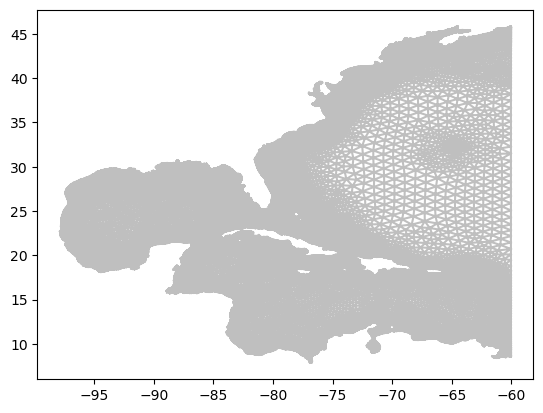

In [20]:
import matplotlib.pyplot as plt

plt.triplot(xs, ys, elements, color="0.75")

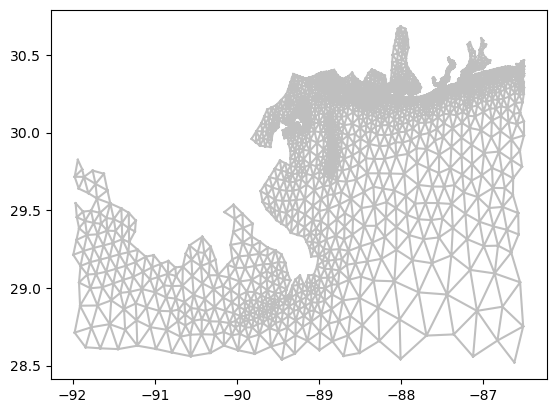

In [21]:
plt.triplot(new_xs, new_ys, relabelled_elements, color="0.75")

In [31]:
from sithom.time import timeit
from sithom.place import BoundingBox

In [32]:
@timeit
def filter_mesh(file_path: str = "../data/fort.63.nc", bbox: BoundingBox = NO_BBOX):
    f63 = xr_loader(file_path)
    xs = f63.x.values
    ys = f63.y.values
    ys_in = (bbox.lat[0] < ys) & (ys < bbox.lat[1])
    xs_in = (bbox.lon[0] < xs) & (xs < bbox.lon[1])
    both_in = xs_in & ys_in
    indices = np.where(both_in)[0]
    new_indices = np.where(indices)[0]
    neg_indices = np.where(~both_in)[0]
    elements = f63.element.values - 1
    mask = ~np.isin(elements, neg_indices).any(axis=1)
    filtered_elements = elements[mask]
    mapping = dict(zip(indices, new_indices))
    relabelled_elements = np.vectorize(mapping.get)(filtered_elements)
    f63_n = f63.isel(node=indices)
    del f63_n["element"]
    # del f63_n["nele"]
    # del f63_n["nvertex"]
    f63_n["element"] = (["nele", "nvertex"], relabelled_elements + 1)
    return f63_n

In [33]:
filter_mesh("../data/fort.63.nc", NO_BBOX)

'filter_mesh'  0.03127 s 



<xarray.Dataset>
Dimensions:      (time: 1008, node: 1899, mesh: 1, nope: 1, neta: 103,
                  nbou: 59, nvel: 4514, nele: 3205, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T00:10:00 ... 2014-05-06
    x            (node) float64 -91.45 -91.21 -91.66 ... -87.42 -87.42 -87.43
    y            (node) float64 28.61 28.63 28.61 28.61 ... 30.47 30.48 30.48
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
    element      (nele, nvertex) int64 17 26 44 18 45 ... 1092 1091 994 1092 993
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            022ef7c
    grid_type:          Triangular
    description:        ADCIRC Example     ! 32 CHARACTER ALPHANUMERIC RUN DE...
    agrid:              eastcoast_95d_ll_select.grd
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [34]:
filter_mesh("../../kat2/fort.63.nc", NO_BBOX)

'filter_mesh'  0.54934 s 



<xarray.Dataset>
Dimensions:      (time: 75, node: 209774, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 417406, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2005-08-23T19:00:00 ... 2005-08-30T12:...
    x            (node) float64 -91.91 -91.97 -91.79 ... -89.77 -89.42 -89.6
    y            (node) float64 28.5 28.56 28.51 28.52 ... 30.31 30.36 30.32
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
    element      (nele, nvertex) int64 4 5 1 1 5 ... 195449 163564 195449 196629
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            022ef7c
    grid_type:          Triangular
    description:        ASGS cs:20050724180000 cy:KATRINA31 ASGS       ! 32 C...
    agrid:              grid
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [24]:
filter_mesh()

<xarray.Dataset>
Dimensions:      (time: 1008, node: 1899, nele: 58369, nvertex: 3, mesh: 1,
                  nope: 1, neta: 103, nbou: 59, nvel: 4514)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T00:10:00 ... 2014-05-06
    x            (node) float64 -91.45 -91.21 -91.66 ... -87.42 -87.42 -87.43
    y            (node) float64 28.61 28.63 28.61 28.61 ... 30.47 30.48 30.48
Dimensions without coordinates: node, nele, nvertex, mesh, nope, neta, nbou,
                                nvel
Data variables:
    element      (nele, nvertex) int32 18760 18493 18761 ... 19058 18754 18755
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
Attributes: (12/49)
    _

In [29]:
f63_n = f63.isel(node=indices)
del f63_n["element"]
print(f63_n)
# del f63_n["nele"]
# del f63_n["nvertex"]
f63_n["element"] = (["nele", "nvertex"], relabelled_elements + 1)

<xarray.Dataset>
Dimensions:      (time: 1008, node: 1899, mesh: 1, nope: 1, neta: 103,
                  nbou: 59, nvel: 4514)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T00:10:00 ... 2014-05-06
    x            (node) float64 -91.45 -91.21 -91.66 ... -87.42 -87.42 -87.43
    y            (node) float64 28.61 28.63 28.61 28.61 ... 30.47 30.48 30.48
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel
Data variables:
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            022ef7c
    grid_type:          Triangular
    description:        A

In [30]:
f63_n

<xarray.Dataset>
Dimensions:      (time: 1008, node: 1899, mesh: 1, nope: 1, neta: 103,
                  nbou: 59, nvel: 4514, nele: 3205, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T00:10:00 ... 2014-05-06
    x            (node) float64 -91.45 -91.21 -91.66 ... -87.42 -87.42 -87.43
    y            (node) float64 28.61 28.63 28.61 28.61 ... 30.47 30.48 30.48
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 ...
    nvdll        (nope) int32 ...
    max_nvdll    int32 ...
    ibtypee      (nope) int32 ...
    nbdv         (neta) int32 ...
    nvell        (nbou) int32 ...
    max_nvell    int32 ...
    ibtype       (nbou) int32 ...
    nbvv         (nvel) int32 ...
    depth        (node) float64 ...
    zeta         (time, node) float64 ...
    element      (nele, nvertex) int64 17 26 44 18 45 ... 1092 1091 994 1092 993
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            022ef7c
    grid_type:          Triangular
    description:        ADCIRC Example     ! 32 CHARACTER ALPHANUMERIC RUN DE...
    agrid:              eastcoast_95d_ll_select.grd
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [41]:
hres = filter_mesh("../../kat2/fort.63.nc", NO_BBOX.pad(0.5))

'filter_mesh'  0.42938 s 



In [46]:
from sithom.plot import plot_defaults

plot_defaults()

Text(0, 0.5, 'Latitude [$^\\circ$N]')

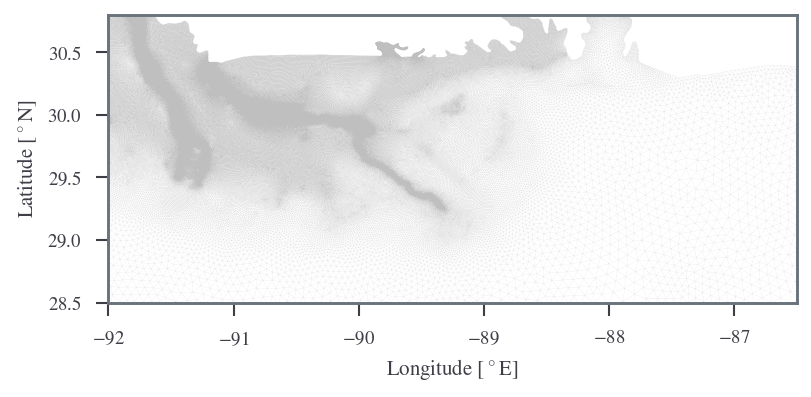

In [48]:
hres = filter_mesh("../../kat2/fort.63.nc", NO_BBOX.pad(0.5))
plt.triplot(
    hres.x.values, hres.y.values, hres.element.values - 1, color="0.75", linewidth=0.05
)
NO_BBOX.ax_lim(plt.gca())
plt.gca().set_aspect("equal")
plt.xlabel("Longitude [$^\circ$E]")
plt.ylabel("Latitude [$^\circ$N]")

'filter_mesh'  0.01563 s 



Text(0, 0.5, 'Latitude [$^\\circ$N]')

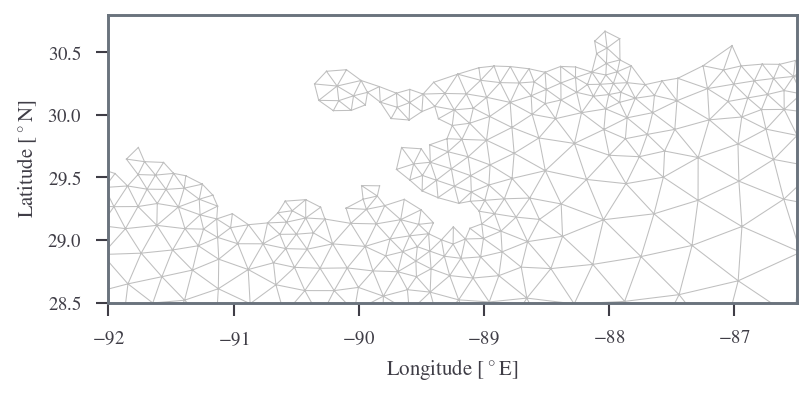

In [50]:
lres = filter_mesh(
    "/work/n01/n01/sithom/adcirc-swan/testsuite/adcirc/adcirc_katrina-2d-nws13-parallel/fort.63.nc",
    NO_BBOX.pad(0.5),
)
plt.triplot(
    lres.x.values, lres.y.values, lres.element.values - 1, color="0.75", linewidth=0.5
)
NO_BBOX.ax_lim(plt.gca())
plt.gca().set_aspect("equal")
plt.xlabel("Longitude [$^\circ$E]")
plt.ylabel("Latitude [$^\circ$N]")